## Meet PyMKS

In this short intro, we will demonstrate how to use 2-point statistics to objectively quantify microstructures, predict effective properties using homogenization and predict local properties using localization. More technical details can be found [in the theory section](THEORY.html).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

##Quantify Microstructures using 2-Point Statistics

Lets make two dual phase microstructures with different morphologies.

In [2]:
from pymks.datasets import make_microstructure

X_1 = make_microstructure(n_samples=1, grain_size=(25, 25))
X_2 = make_microstructure(n_samples=1, grain_size=(15, 95))

X = np.concatenate((X_1, X_2))

Throughout PyMKS `X` is used to represent microstructures. Now that we have made the two microstructures, lets take a look at them.

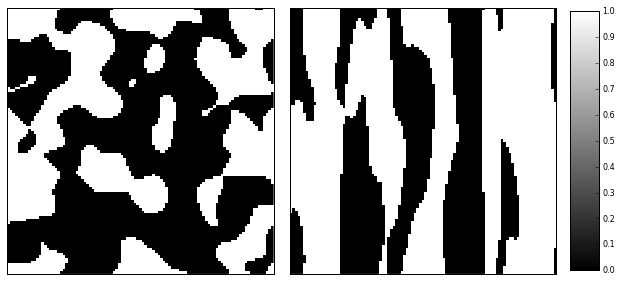

In [3]:
from pymks.tools import draw_microstructures

draw_microstructures(X)

We can compute their 2-point statistics for these two periodic microstructures using the `correlate` function from `pymks.stats`. This function computes all of the autocorrelations and cross-correlation(s) for a microstructure. Before we compute the 2-point statistics, we will discretize them using the `DiscreteIndicatorBasis` function.

In [72]:
from pymks import DiscreteIndicatorBasis
from pymks.stats import correlate

dbasis = DiscreteIndicatorBasis(n_states=2, domain=[0, 1])
X_ = dbasis.discretize(X)
X_corr = correlate(X_, periodic_axes=[0, 1])

Let's take a look at the two autocorrelations and the cross-correlation for these two microstructures.

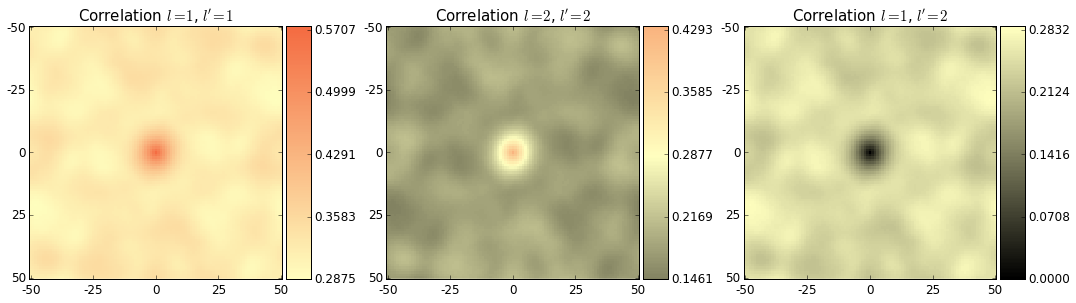

In [5]:
from pymks.tools import draw_correlations

draw_correlations(X_corr[0])

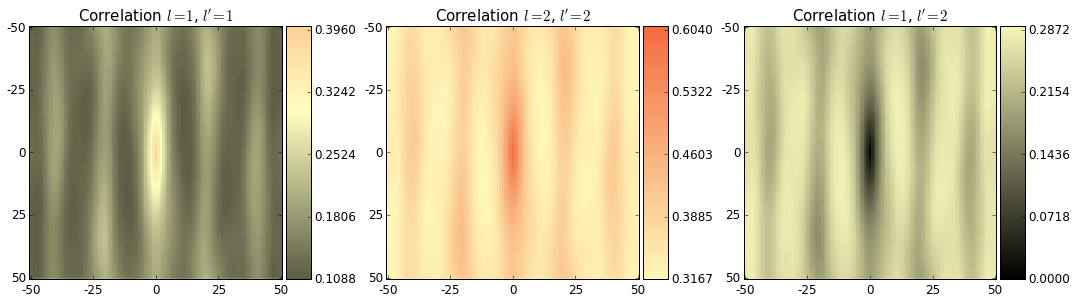

In [6]:
draw_correlations(X_corr[1])

2-Point statistics provide an object way to compare microstructures, and have been shown as an effective input to machine learning methods.

##Predict Homogenize Properties

In this section of the intro, we are going to predict the effective stiffness for two phase microstructures using the `MKSHomogenizationModel`, but we could have chosen any other effective material property.  

First we need to make some microstructures and their effective stress values to fit our model with. Let's create 200 examples of 3 different types of microstructures, totaling 600 microstructures.

In [54]:
from pymks.datasets import make_elastic_stress_random

grain_size = [(37, 6), (4, 39), (14, 14)]
n_samples = [200, 200, 200]

X_train, y_train = make_elastic_stress_random(n_samples=n_samples, size=(51, 51),
                                              grain_size=grain_size, seed=1)

Once again, `X_train` is our microstructures. Throughout PyMKS `y` is used as either the prpoerty or the field we would like to predict. In this case `y_train` is the effective stress values for `X_train`. Let's look at one of each of the three different types of microstructures.

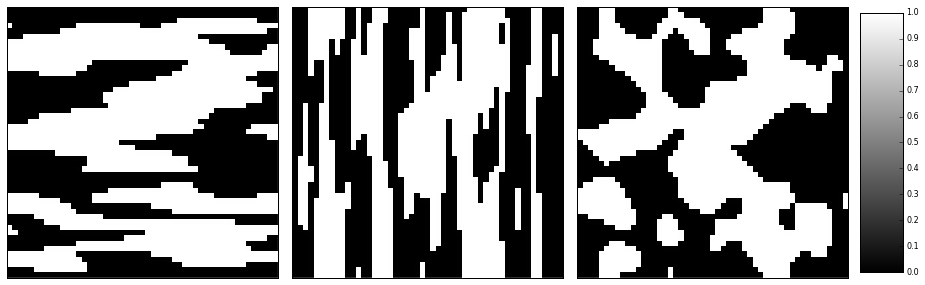

In [55]:
draw_microstructures(X_train[::200])

The `MKSHomogenizationModel` uses 2-point statistics, so we need provide a basis function to discretize the microstructure with.

In [67]:
from pymks import MKSHomogenizationModel

dbasis = DiscreteIndicatorBasis(n_states=2, domain=[0, 1])
homogenize_model = MKSHomogenizationModel(basis=dbasis)

Let's fit our model.

In [66]:
homogenize_model.fit(X_train, y_train, periodic_axes=[0, 1])

Now let's make some new data to see how good our model is.

In [62]:
n_samples = [10, 10, 10]
X_test, y_test = make_elastic_stress_random(n_samples=n_samples, size=(51, 51),
                                            grain_size=grain_size, seed=100)

We will try and predict the effective stress of our `X_test` microstructures.

In [63]:
y_pred = homogenize_model.predict(X_test, periodic_axes=[0, 1])

The `MKSHomogenizationModel` generates low dimensional representations of microstructures and regression methods to predict effective properties. Let's take a look at the low dimensional representations.

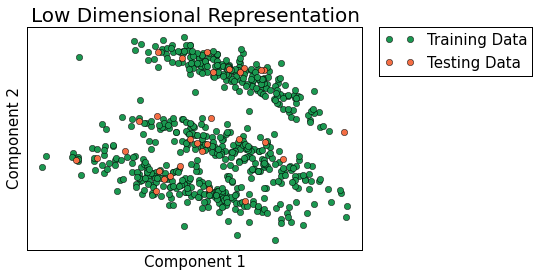

In [64]:
from pymks.tools import draw_components

draw_components(homogenize_model.fit_data, homogenize_model.predict_data, 
                label_1='Training Data', label_2='Testing Data')

Now let's look at a goodness of fit plot for our `MKSHomogenizationModel`.

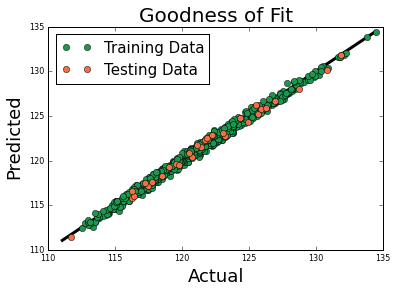

In [65]:
from pymks.tools import draw_goodness_of_fit

fit_data = np.array([y_train, 
                     homogenize_model.predict(X_train, periodic_axes=[0, 1])])
pred_data = np.array([y_test, y_pred])

draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Testing Data'])

Looks good.

The `MKSHomogenizationModel` can be used to predict effective properties and processing-structure evolutions.

##Predict Local Properties

In this section of the intro, we are going to predict the local strain field in a microstructure using `MKSLocalizationModel`, but we could have predicted another local property.

First we need some data, so let's make some.

In [13]:
from pymks.datasets import make_elastic_FE_strain_delta

X_delta, y_delta = make_elastic_FE_strain_delta()

Once again, `X_delta` is our microstructures and `y_delta` is our local strain fields. We need to discretize the microstructure again so we will also use the same basis function.

In [14]:
from pymks import MKSLocalizationModel

dbasis = DiscreteIndicatorBasis(n_states=2)
localize_model = MKSLocalizationModel(basis=dbasis)

Let's use the data to fit our `MKSLocalizationModel`.

In [ ]:
localize_model.fit(X_delta, y_delta)

Now that we have fit our model, we will create a random microstructure and compute its local strain field using finite element analysis. We will then try and reproduce the same strain field with our model.

In [70]:
from pymks.datasets import make_elastic_FE_strain_random

X_test, y_test = make_elastic_FE_strain_random()

Let's look at the microstructure and its local strain field.

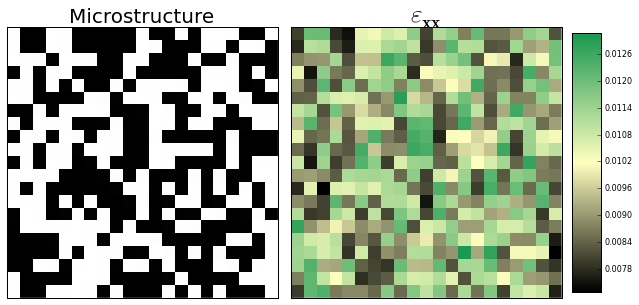

In [71]:
from pymks.tools import draw_microstructure_strain

draw_microstructure_strain(X_test[0], y_test[0])

Now let's pass that same microstructure to our `MKSLocalizationModel` and compare the predicted and computed local strain fields.

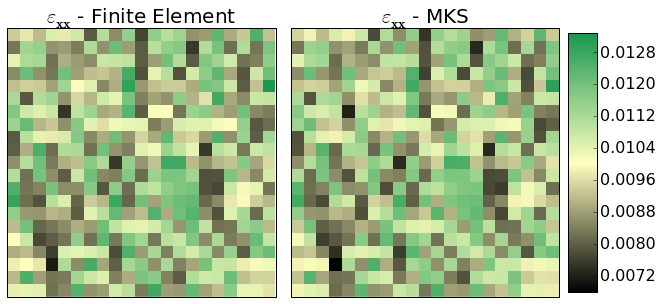

In [15]:
from pymks.tools import draw_strains_compare


y_pred = localize_model.predict(X_test)
draw_strains_compare(y_test[0], y_pred[0])

Not bad!

The `MKSLocalizationModel` can be used to predict local properties and local processing-structure evolutions.